In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [12]:
# Load each file separately
file_paths = {
    "Beijing": "/Users/saghararab/Desktop/Cities/Beijing_labeled.csv",
    "Shenyang": "/Users/saghararab/Desktop/Cities/Shenyang_labeled.csv",
    "Guangzhou": "/Users/saghararab/Desktop/Cities/Guangzhou_labeled.csv",
    "Shanghai": "/Users/saghararab/Desktop/Cities/Shanghai_labeled.csv"
}

In [13]:
#dataSets
datasets = {city: pd.read_csv(path) for city, path in file_paths.items()}
print(datasets)

# Training data
X_train = np.vstack([datasets["Beijing"].iloc[:, 0:9].values, datasets["Shenyang"].iloc[:, 0:9].values])
y_train = np.hstack([datasets["Beijing"].iloc[:, 10].values, datasets["Shenyang"].iloc[:, 10].values])

#Testing data
X_test = np.vstack([datasets["Guangzhou"].iloc[:, 0:9].values, datasets["Shanghai"].iloc[:, 0:9].values])
y_test = np.hstack([datasets["Guangzhou"].iloc[:, 10].values, datasets["Shanghai"].iloc[:, 10].values])

{'Beijing':       season  DEWP  HUMI    PRES  TEMP     Iws  precipitation  cbwd_NE  \
0          4  -8.0  79.0  1026.0  -5.0   23.69            0.0        0   
1          4 -11.0  85.0  1021.0  -9.0  105.93            1.1        0   
2          4 -21.0  43.0  1030.0 -11.0  117.55            0.0        0   
3          4 -25.0  33.0  1034.0 -12.0   39.35            0.0        1   
4          4 -24.0  30.0  1034.0 -10.0   59.00            0.0        1   
...      ...   ...   ...     ...   ...     ...            ...      ...   
2066       4 -15.0  45.0  1040.0  -5.0    1.79            0.0        0   
2067       4 -13.0  34.0  1036.0   1.0   40.24            0.0        0   
2068       4  -8.0  50.0  1028.0   1.0    1.79            0.0        0   
2069       4 -11.0  28.0  1031.0   6.0   23.24            0.0        0   
2070       4 -10.0  37.0  1033.0   3.0    0.89            0.0        0   

      cbwd_NW  cbwd_SE  PM_HIGH  
0           0        1      1.0  
1           0        1      0.0

In [14]:
#Define a class for the classifier
class k_means_classifier():
    def __init__(self, n_clusters=5, random_state=42):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        self.cluster_labels = None

    #Train the model throughout making clusters 
    def fit(self, X, y):
        """ Trains K-Means and determines which label (0 or 1) each cluster gets. """
        self.kmeans.fit(X)  
        clusters = self.kmeans.labels_  

        self.cluster_labels = {} 

        for cluster in range(self.n_clusters):  
            cluster_points = y[clusters == cluster].astype(int) 
            if len(cluster_points) > 0: 
                self.cluster_labels[cluster] = np.bincount(cluster_points).argmax() 
    
    #Classify new data points by finding the closest cluster
    def predict(self, X):
        """ Predicts labels based on the nearest cluster center. """
        cluster_assignments = self.kmeans.predict(X)
        return np.array([self.cluster_labels.get(c, 0) for c in cluster_assignments])  # Default 0 om klustret saknas

    #Evaluate the model by calculating how often it gets it right (Calculate accuracy)
    def score(self, X, y_true):
        """ Calculate accuracy. """
        y_pred = self.predict(X)
        return accuracy_score(y_true, y_pred)

# Train and evaluate the model
classifier = k_means_classifier(n_clusters=5)
classifier.fit(X_train, y_train)
  

In [15]:
#Calculate accuracy
train_accuracy = classifier.score(X_train, y_train)
test_accuracy = classifier.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 72.64%
Testing Accuracy: 44.99%


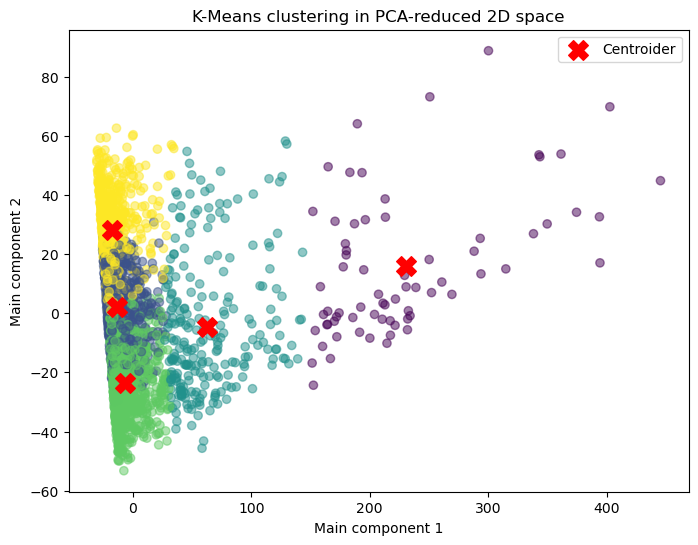

In [25]:
#Using Principal component analysis to see the clsuters from K_mean
#The red cross is centers of each cluster 

#Reduce dimensions to 2D with PCA to be able to plot
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)


train_clusters = classifier.kmeans.predict(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', alpha=0.5)
plt.scatter(pca.transform(classifier.kmeans.cluster_centers_)[:, 0], 
            pca.transform(classifier.kmeans.cluster_centers_)[:, 1], 
            c='red', marker='X', s=200, label="Centroider")  # Mark centroider
plt.title("K-Means clustering in PCA-reduced 2D space")
plt.xlabel("Main component 1")
plt.ylabel("Main component 2")
plt.legend()
plt.show()

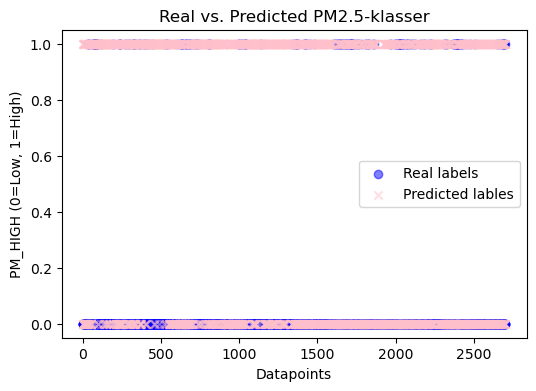

In [26]:
#The scatter plot below compares the actual PM2.5 classes with the predicted classes from the K-Means model
y_pred = classifier.predict(X_test)
plt.figure(figsize=(6, 4))
plt.scatter(range(len(y_test)), y_test, label="Real labels", alpha=0.5, marker='o', color='blue')
plt.scatter(range(len(y_pred)), y_pred, label="Predicted lables", alpha=0.5, marker='x', color='pink')
plt.xlabel("Datapoints")
plt.ylabel("PM_HIGH (0=Low, 1=High)")
plt.title("Real vs. Predicted PM2.5-klasser")
plt.legend()
plt.show()